In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *


Using TensorFlow backend.


In [2]:

def load_dummy_predictor() :

    def _initialize_predictor_weights(predictor_model) :
        #Load pre-trained model
        print("I am a placeholder function.")

    def _load_predictor_func(sequence_input) :
        
        def score_motif(pwm) :
            #Score GTT motifs in the first 30nt of input sequence (placeholder example of a predictor network)
            motif_score = K.sum(pwm[..., :30-2, 2, :] * pwm[..., 1:30-1, 3, :] * pwm[..., 2:30, 3, :], axis=-2)
    
            return motif_score
        
        counting_layer = Lambda(lambda x: score_motif(x))
        pred_score = counting_layer(sequence_input)

        predictor_inputs = []
        predictor_outputs = [pred_score]

        return predictor_inputs, predictor_outputs, _initialize_predictor_weights

    return _load_predictor_func


In [3]:

#Define target isoform loss function
def get_example_loss(target_score=10, opt_start=0, opt_end=30, opt_target_bits=1.8, entropy_weight=0.0) :
    
    opt_entropy_mse = get_target_entropy_sme(pwm_start=opt_start, pwm_end=opt_end, target_bits=opt_target_bits)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        score_loss = 1.0 * K.mean((pred_score - target_score)**2, axis=0)
        
        seq_loss = 0.0
        
        entropy_loss = entropy_weight * opt_entropy_mse(pwm)
        
        #Compute total loss
        total_loss = score_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


def get_revcomp_transform() :
    
    def transform_func(pwm) :
        
        pwm_opt = pwm[..., :30, :, :]
        
        a_band = K.expand_dims(pwm_opt[..., :, 0, :], axis=-2)
        c_band = K.expand_dims(pwm_opt[..., :, 1, :], axis=-2)
        g_band = K.expand_dims(pwm_opt[..., :, 2, :], axis=-2)
        t_band = K.expand_dims(pwm_opt[..., :, 3, :], axis=-2)
        
        rev_comp_pwm = K.concatenate([
            t_band,
            g_band,
            c_band,
            a_band
        ], axis=-2)[..., ::-1, :, :]
        
        return K.concatenate([pwm_opt, rev_comp_pwm], axis=-3)
    
    return transform_func

def get_revcomp_transform_opt() :
    
    def transform_func(pwm) :
        
        return K.concatenate([pwm[..., :30, :, :], pwm[..., :30, :, :][..., ::-1, ::-1, :]], axis=-3)
    
    return transform_func


In [12]:

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, transform_funcs, n_sequences=1, n_samples=1, eval_mode='pwm', n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_scores = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=60, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True, pwm_transform_func=transform_func)
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_dummy_predictor(), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.1)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        measure_func = lambda pred_outs: pred_outs[0][0, :, :] if len(pred_outs[0].shape) > 2 else pred_outs[0]
        
        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Motif Score', plot_pwm_start=0, plot_pwm_end=60, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, pred_score = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_scores.append(pred_score)

    return optimized_pwms, optimized_scores



Running optimization experiment
Optimizing objective 0...
I am a placeholder function.
Epoch 1/1
2000/2000 [==============================] - 9s 4ms/step - loss: 120.5265


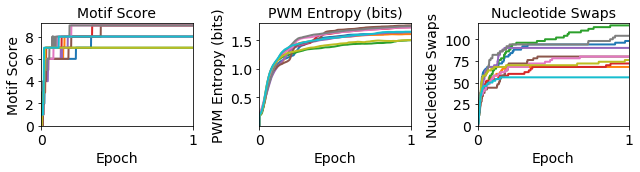

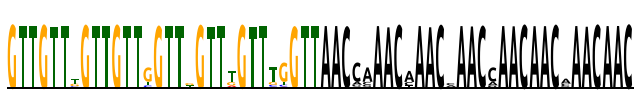

In [14]:

seq_template = 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTTTTTTTTTXXXXXXXXXXXXXXXXXXXX'
library_context = 'simple'

#Run SeqProp Optimization

print("Running optimization experiment")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

#Either 'pwm' for relaxed/continuous pwm input sent to the predictor, or 'sample' for proper sampled onehots
eval_mode='sample'

sequence_templates = [
    seq_template
]

losses = [
    get_example_loss(
        target_score=10.,
        opt_start=0,
        opt_end=30,
        opt_target_bits=1.8,
        entropy_weight=0.0
    )
]

transforms = [
    get_revcomp_transform_opt()
]

pwms, scores = run_seqprop(sequence_templates, losses, transforms, n_sequences, n_samples, eval_mode, n_epochs, steps_per_epoch)

